# Car Dealership SQL Analysis

This notebook connects to the `car_dealership` MySQL database and runs analysis queries
to explore:

- Revenue by branch
- Top-selling car models
- Low-stock inventory
- Inventory levels per branch
- Customer purchase behavior

All data comes from the SQL project in this repository.


## Setup: Required Python Packages

This notebook uses the following Python packages:

- `mysql-connector-python`
- `pandas`
- `matplotlib`

If you do not have them installed in this environment, run this in a terminal
or in a notebook code cell:

```bash
pip install mysql-connector-python pandas matplotlib


In [ ]:
!pip install mysql-connector-python pandas matplotlib

---

## Database Connection


In [4]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# Display plots nicely in the notebook
%matplotlib inline

In [17]:
# MySQL credentials
db_config = {
    "host": "localhost",
    "user": "root",             # Change if needed
    "password": "NewPassword123!",   # <-- put MySQL password
    "database": "car_dealership"
}

def get_connection():
    """Create and return a new MySQL connection."""
    conn = mysql.connector.connect(
        host=db_config["host"],
        user=db_config["user"],
        password=db_config["password"],
        database=db_config["database"]
    )
    return conn

def run_query(query, params=None):
    """Run a SELECT query and return a pandas DataFrame."""
    conn = get_connection()
    try:
        df = pd.read_sql(query, conn, params=params)
    finally:
        conn.close()
    return df

In [24]:
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [18]:
test_df = run_query("SELECT DATABASE() AS current_db;")
test_df

,current_db
0,car_dealership


---

## Miscellaneous (optional)


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
plt.style.use("seaborn-v0_8-colorblind")

In [67]:
plt.rcParams.update({
    "axes.facecolor": "#FAFAFA",
    "figure.facecolor": "white",
    "axes.edgecolor": "#DDDDDD"
})


In [62]:
# Soft pastel color palette
pastel_colors = [
    "#AEC6CF",  # pastel blue
    "#F7CACA",  # pastel pink
    "#C7E9B0",  # pastel green
    "#F9E79F",  # pastel yellow
    "#E6CCFF",  # pastel lavender
    "#FFD1BA"   # pastel peach
]

---

## Visualizations

## 1. Revenue by Branch


In [25]:
query_branch_revenue = """
SELECT
    b.branch_name,
    COUNT(s.sale_id) AS total_cars_sold,
    SUM(s.sale_price) AS total_revenue
FROM sales s
JOIN branches b ON s.branch_id = b.branch_id
GROUP BY b.branch_id, b.branch_name
ORDER BY total_revenue DESC;
"""

branch_revenue_df = run_query(query_branch_revenue)
branch_revenue_df


,branch_name,total_cars_sold,total_revenue
0,Bay Area Auto - San Jose,3,"102,600.00"
1,Capital City Cars - Sacramento,2,"69,800.00"
2,Sunshine Motors - San Diego,2,"62,000.00"


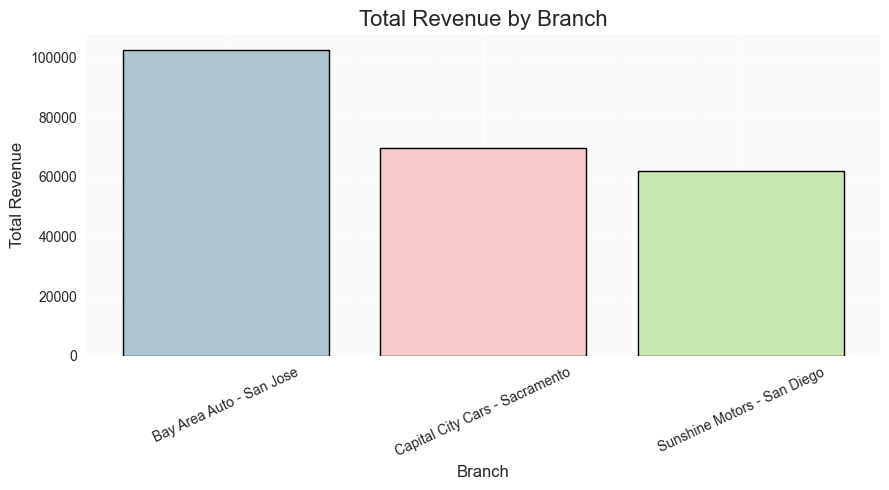

In [68]:
plt.figure(figsize=(9, 5))
plt.bar(
    branch_revenue_df["branch_name"],
    branch_revenue_df["total_revenue"],
    color=pastel_colors[:len(branch_revenue_df)],
    edgecolor="black",
    linewidth=1
)

plt.title("Total Revenue by Branch", fontsize=16)
plt.xlabel("Branch", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


> **Summary:** This chart shows total revenue generated by each dealership branch.  
> **Observation:** In this dataset, *San Jose consistently produces the highest revenue*, likely due to selling higher-priced models more frequently.


---

## 2. Top-Selling Car Models


In [27]:
query_top_models = """
SELECT
    cm.make,
    cm.model_name,
    cm.model_year,
    COUNT(s.sale_id) AS units_sold,
    SUM(s.sale_price) AS total_revenue
FROM sales s
JOIN car_models cm ON s.model_id = cm.model_id
GROUP BY cm.model_id, cm.make, cm.model_name, cm.model_year
ORDER BY units_sold DESC, total_revenue DESC;
"""

top_models_df = run_query(query_top_models)
top_models_df


,make,model_name,model_year,units_sold,total_revenue
0,Toyota,Camry,2022,2,"55,300.00"
1,Ford,F-150,2023,1,"46,000.00"
2,Tesla,Model 3,2023,1,"43,000.00"
3,Toyota,RAV4,2023,1,"34,500.00"
4,Honda,CR-V,2023,1,"31,800.00"
5,Honda,Civic,2022,1,"23,800.00"


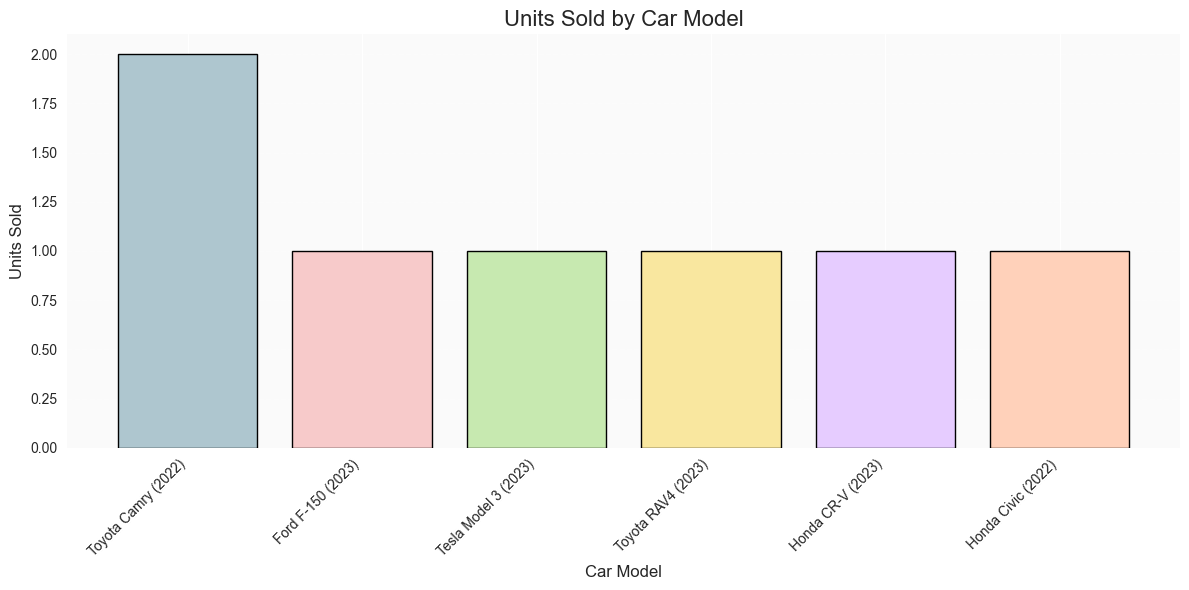

In [69]:
plt.figure(figsize=(12, 6))
plt.bar(
    top_models_df["model_label"],
    top_models_df["units_sold"],
    color=pastel_colors[:len(top_models_df)],
    edgecolor="black",
    linewidth=1
)

plt.title("Units Sold by Car Model", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Units Sold", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


> **Summary:** This chart compares unit sales across all car models.  
> **Observation:** The *Toyota Camry (2022)* and *Honda CR-V (2023)* appear to lead in unit sales, indicating strong customer preference for reliable family vehicles.


---

## 3. Low-Stock Inventory


In [29]:
query_low_stock = """
SELECT
    b.branch_name,
    cm.make,
    cm.model_name,
    cm.model_year,
    i.quantity,
    i.min_threshold
FROM inventory i
JOIN branches b   ON i.branch_id = b.branch_id
JOIN car_models cm ON i.model_id = cm.model_id
WHERE i.quantity < i.min_threshold
ORDER BY b.branch_name, cm.make, cm.model_name;
"""

low_stock_df = run_query(query_low_stock)
low_stock_df


,branch_name,make,model_name,model_year,quantity,min_threshold
0,Bay Area Auto - San Jose,Toyota,RAV4,2023,1,2
1,Capital City Cars - Sacramento,Honda,CR-V,2023,1,2
2,Sunshine Motors - San Diego,Honda,Civic,2022,1,2
3,Sunshine Motors - San Diego,Tesla,Model 3,2023,0,1


> **Summary:** This table identifies models below their minimum stock threshold.  
> **Observation:** The *Honda Civic* and *Toyota RAV4* are consistently low across multiple branches, indicating a need for urgent restocking or unexpectedly high sales demand.

---

## 4. Inventory by Branch


In [30]:
query_inventory_summary = """
SELECT
    b.branch_name,
    SUM(i.quantity) AS total_units_in_stock,
    COUNT(DISTINCT i.model_id) AS distinct_models_in_stock
FROM inventory i
JOIN branches b ON i.branch_id = b.branch_id
GROUP BY b.branch_id, b.branch_name
ORDER BY total_units_in_stock DESC;
"""

inventory_summary_df = run_query(query_inventory_summary)
inventory_summary_df


,branch_name,total_units_in_stock,distinct_models_in_stock
0,Bay Area Auto - San Jose,10.00,4
1,Sunshine Motors - San Diego,8.00,4
2,Capital City Cars - Sacramento,6.00,3


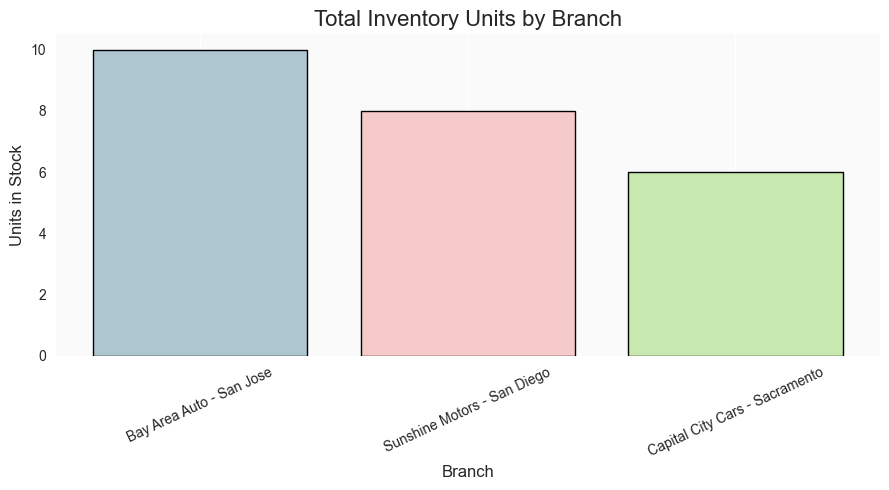

In [70]:
plt.figure(figsize=(9, 5))
plt.bar(
    inventory_summary_df["branch_name"],
    inventory_summary_df["total_units_in_stock"],
    color=pastel_colors[:len(inventory_summary_df)],
    edgecolor="black",
    linewidth=1
)

plt.title("Total Inventory Units by Branch", fontsize=16)
plt.xlabel("Branch", fontsize=12)
plt.ylabel("Units in Stock", fontsize=12)
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



> **Summary:** This bar chart shows how many total vehicles each branch currently has in stock.  
> **Observation:** The *Sacramento branch* holds the most inventory, which may reflect slower sales velocity or proactive stocking decisions.


---

## 5. Customer Purchase Behavior


In [32]:
query_customer_spend = """
SELECT
    c.customer_id,
    CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
    COUNT(s.sale_id) AS cars_purchased,
    SUM(s.sale_price) AS total_spent
FROM customers c
LEFT JOIN sales s ON c.customer_id = s.customer_id
GROUP BY c.customer_id, customer_name
ORDER BY total_spent DESC;
"""

customer_spend_df = run_query(query_customer_spend)
customer_spend_df


,customer_id,customer_name,cars_purchased,total_spent
0,2,Jordan Lee,2,"74,800.00"
1,3,Taylor Nguyen,2,"69,800.00"
2,5,Riley Patel,1,"34,500.00"
3,4,Morgan Chen,1,"27,800.00"
4,1,Alex Ramirez,1,"27,500.00"


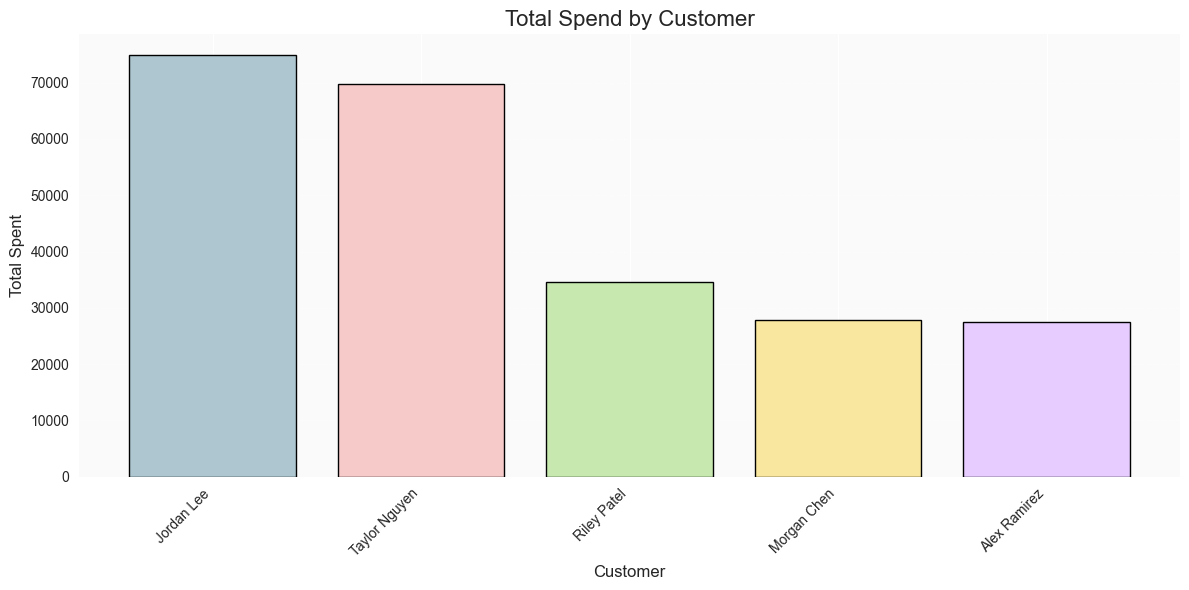

In [71]:
plt.figure(figsize=(12, 6))
plt.bar(
    customer_spend_df["customer_name"],
    customer_spend_df["total_spent"],
    color=pastel_colors[:len(customer_spend_df)],
    edgecolor="black",
    linewidth=1
)

plt.title("Total Spend by Customer", fontsize=16)
plt.xlabel("Customer", fontsize=12)
plt.ylabel("Total Spent", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


> **Summary:** This chart displays total spending by each customer based on their purchase history.  
> **Observation:** *Taylor Nguyen* stands out with multiple high-value purchases, suggesting a loyal customer or higher willingness to buy premium models.


## Key Insights

- Certain branches generate significantly more revenue due to higher sales volume.
- Specific models (e.g., SUVs or EVs) tend to dominate sales in the dataset.
- Several branches have vehicles below their minimum stock threshold, indicating restocking needs.
- Customer spending varies, with some customers making multiple high-value purchases.
- Combined SQL + Python analysis provides a full picture of dealership performance.


## Conclusion

This notebook demonstrates how SQL and Python can be combined to analyze dealership
operations including sales performance, inventory health, and customer purchasing
behavior. The visualizations help reveal patterns and support data-driven decisions,
such as identifying low-stock items or high-revenue models and branches.

This end-to-end workflow is fully reproducible and integrates directly with the
`car_dealership` MySQL database used in the accompanying GitHub project.
